In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import sys
import logging
import warnings
from functools import reduce
import scipy
from scipy import stats
import numpy
import numpy as np
import astropy.units as u
import astropy.constants as const
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion
from matplotlib import pyplot
from matplotlib import pyplot as plt
pyplot.style.use("tlrh")

# This repo: src folder /w Python scripts
sys.path.append("../src")
from tt_orbit_galpy import plot_ttensor
from tt_orbit_galpy import plot_orbit_Rz
from tt_orbit_galpy import plot_orbit_xyz
from tt_orbit_galpy import plot_potential
from tt_orbit_galpy import integrate_and_print_info

# Other repos linked into the notebook container ;-)
sys.path.append("../../supaharris")
from data.parse_hilker_2019 import parse_hilker_2019_orbits
from data.parse_hilker_2019 import parse_hilker_2019_combined
from data.parse_hilker_2019 import parse_baumgardt_2019_mnras_482_5138_table1
from data.parse_hilker_2019 import parse_individual_rvs_of_stars_in_field_of_clusters

sys.path.append("../../supaharris-client")
from supaharrisclient.utils import suppress_stdout
from supaharrisclient.units import arcmin2parsec, parsec2arcmin
from supaharrisclient.client import SupaHarrisClient

logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

# Get data

In [3]:
# Sets the Parameter, Reference, AstroObject, AstroObjectClassification, and Observation instances
shc = SupaHarrisClient(base_url="https://nginx/api/v1/", loglevel=logging.CRITICAL, verify=False)

### What does the distribution of orbital periods of MW GCs look like?

In [27]:
ts = numpy.linspace(0.0, 1, 8096+1) * u.Gyr
to_Gyr = bovy_conversion.time_in_Gyr(220.0, 8.0)

MW_Tr_Myr = []
required_parameters = ["RA", "Dec", "R_Sun", "v_r", "pmRA", "pmDec", "R_peri", "R_apo",]
for i, gc_name in enumerate(shc.observations["name"]): 
    # if i > 0: break
    print("           {:<15s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}".format(
        *["name"]+required_parameters)
    )
    try:
        with warnings.catch_warnings(record=True) as w:
            o = Orbit.from_name(gc_name)
            o.integrate(ts, MWPotential2014)
    except ValueError as e:
        print("SIMBAD     {:<15s} died with error".format(gc_name))
    else:
        print("SIMBAD     {:<15s}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
            o.name, o.ra(), o.dec(), o.dist(), o.vlos(), o.pmra(), o.pmdec(), o.rperi(), o.rap()
        ))

    for required_parameter in required_parameters:
        if (shc.observations[required_parameter][i] == "" 
                or shc.observations[required_parameter][i] == "None"):
            print("SupaHarris {:<15s} cannot provide parameter {}".format(gc_name, required_parameter))
            break
    else:  # no break means we have all required data
       
        RA = float(shc.observations["RA"][i])
        Dec = float(shc.observations["Dec"][i])
        R_Sun = float(shc.observations["R_Sun"][i])
        v_r = float(shc.observations["v_r"][i])
        pmRA = float(shc.observations["pmRA"][i])
        pmDec = float(shc.observations["pmDec"][i])
        R_peri = float(shc.observations["R_peri"][i])
        R_apo = float(shc.observations["R_apo"][i])
        print("SupaHarris {:<15s}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
            gc_name, RA, Dec, R_Sun, v_r, pmRA, pmDec, R_peri, R_apo
        ))  
        # print("\nMass:    {:.2e}\nr_t:     {:.2f}\nt_cross: {:.2f} (at the tidal radius)\n".format(mass, r_t, t_cross))
            
        o = Orbit([
            RA*u.deg, Dec*u.deg, R_Sun*u.kpc,  # RA (deg), DEC (deg), d (kpc)
            pmRA*u.mas/u.year, pmDec*u.mas/u.year,  # mu_ra (mas/yr), mu_dec (mas/yr)
            v_r*u.km/u.s],  # radial velocity (km/s)
            radec=True, uvw=False, lb=False  # explicit tell Orbit init which input method we use
        )
        o.integrate(ts, MWPotential2014)
        print("Orbit      {:<15s}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
            gc_name, o.ra(), o.dec(), o.dist(), v_r, o.pmra(), o.pmdec(), o.rperi(), o.rap()
        ))
        
        # Galpy's Orbit class can calculate the radial orbital period /w o.Tr(potential). It uses black magic
        # actionsFreqsAngles /w output: (jr,lz,jz,Omegar,Omegaphi,Omegaz,angler,anglephi,anglez)
        Tr_Myr = 1000 * o.Tr(pot=MWPotential2014)  # Gyr
        print("  --> (radial) orbital period {:.2f} Myr\n".format(Tr_Myr))
        MW_Tr_Myr.append(Tr_Myr)

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 104        6.02      -72.08    4.50      -17.21    5.24      -2.52     5.34      7.40      
SupaHarris NGC 104        6.02      -72.08    4.50      -18.00    5.25      -2.53     5.46      7.44      
Orbit      NGC 104        6.02      -72.08    4.50      -18.00    5.25      -2.53     5.38      7.40      
  --> (radial) orbital period 133.59 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 288        13.19     -26.58    8.90      -44.83    4.27      -5.64     2.79      12.21     
SupaHarris NGC 288        13.19     -26.58    8.90      -45.40    4.22      -5.65     3.33      13.01     
Orbit      NGC 288        13.19     -26.58    8.90      -45.40    4.22      -5.65     2.73      12.23     
  --> (radial) orbital period 168.67 Myr

           name           RA        Dec       R_Sun     v_r 

  --> (radial) orbital period 731.91 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     Pal 4          172.32    28.97     108.70    72.40     -0.13     -0.52     71.81     117.58    
SupaHarris Pal 4          172.32    28.97     108.70    74.50     -0.21     -0.39     23.66     111.35    
Orbit      Pal 4          172.32    28.97     108.70    74.50     -0.21     -0.39     55.28     117.97    
  --> (radial) orbital period 1857.92 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     Ko 1            died with error
SupaHarris Ko 1            cannot provide parameter v_r
           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 4147       182.53    18.54     19.30     179.52    -1.71     -2.11     1.35      28.23     
SupaHarris NGC 4147       182.53    18.54     19.30     183.20    -

SIMBAD     NGC 5897       229.35    -21.01    12.50     101.31    -5.43     -3.44     2.86      10.09     
SupaHarris NGC 5897       229.35    -21.01    12.50     101.50    -5.41     -3.46     2.86      9.31      
Orbit      NGC 5897       229.35    -21.01    12.50     101.50    -5.41     -3.46     2.86      10.06     
  --> (radial) orbital period 143.82 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 5904       229.64    2.08      7.50      53.70     4.08      -9.85     2.44      34.41     
SupaHarris NGC 5904       229.64    2.08      7.50      53.20     4.06      -9.89     2.90      24.20     
Orbit      NGC 5904       229.64    2.08      7.50      53.20     4.06      -9.89     2.42      34.41     
  --> (radial) orbital period 466.04 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 5927       232.00    -50.67    7.70      -104

Orbit      NGC 6218       251.81    -1.95     4.80      -41.40    -0.15     -6.77     2.01      4.76      
  --> (radial) orbital period 72.71 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     FSR 1735       253.04    -47.06    10.80     5.00      -5.01     -0.14     0.66      5.60      
SupaHarris FSR 1735        cannot provide parameter v_r
           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6235       253.35    -22.18    11.50     126.68    -3.97     -7.62     3.22      8.99      
SupaHarris NGC 6235       253.36    -22.18    11.50     87.30     -3.96     -7.61     5.43      21.81     
Orbit      NGC 6235       253.36    -22.18    11.50     87.30     -3.96     -7.61     3.49      7.59      
  --> (radial) orbital period 118.00 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBA

Orbit      NGC 6355       260.99    -26.35    9.20      -176.90   -4.61     -0.50     0.50      3.18      
  --> (radial) orbital period 50.48 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6352       261.37    -48.42    5.60      -125.63   -2.17     -4.40     2.89      3.82      
SupaHarris NGC 6352       261.37    -48.42    5.60      -137.00   -2.15     -4.38     2.98      3.59      
Orbit      NGC 6352       261.37    -48.42    5.60      -137.00   -2.15     -4.38     2.94      4.07      
  --> (radial) orbital period 67.18 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     IC 1257        261.78    -7.09     25.00     -137.97   -0.93     -1.41     1.10      18.70     
SupaHarris IC 1257        261.79    -7.09     25.00     -140.20   -0.92     -1.39     2.01      18.05     
Orbit      IC 1257        261.79    -7.09     25.00     -140.2

SIMBAD     Terzan 5       267.02    -24.78    6.90      -81.40    -1.56     -4.72     0.22      1.45      
SupaHarris Terzan 5       267.02    -24.78    6.90      -93.00    -1.71     -4.64     0.82      2.83      
Orbit      Terzan 5       267.02    -24.78    6.90      -93.00    -1.71     -4.64     0.18      1.50      
  --> (radial) orbital period 24.70 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6440       267.22    -20.36    8.50      -69.39    -1.07     -3.83     0.33      1.67      
SupaHarris NGC 6440       267.22    -20.36    8.50      -76.60    -1.01     -3.81     0.30      1.53      
Orbit      NGC 6440       267.22    -20.36    8.50      -76.60    -1.01     -3.81     0.37      1.66      
  --> (radial) orbital period 26.76 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6441       267.55    -37.05    11.60     17.27 

SIMBAD     NGC 6553       272.32    -25.91    6.00      0.72      0.25      -0.41     1.98      2.93      
SupaHarris NGC 6553       272.32    -25.91    6.00      -3.20     0.30      -0.41     1.29      2.35      
Orbit      NGC 6553       272.32    -25.91    6.00      -3.20     0.30      -0.41     1.96      2.95      
  --> (radial) orbital period 47.50 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     2MS-GC02        died with error
SupaHarris 2MS-GC02       272.40    -20.78    4.90      -238.00   -1.97     -3.72     0.48      2.43      
Orbit      2MS-GC02       272.40    -20.78    4.90      -238.00   -1.97     -3.72     0.33      5.50      
  --> (radial) orbital period 62.33 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6558       272.57    -31.76    7.40      -195.70   -1.81     -4.13     0.23      2.46      
SupaHarris NGC 6558

  --> (radial) orbital period 56.93 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6715       283.76    -30.48    26.50     143.06    -2.71     -1.35     18.89     85.24     
SupaHarris NGC 6715       283.76    -30.48    26.50     141.30    -2.73     -1.38     12.58     36.93     
Orbit      NGC 6715       283.76    -30.48    26.50     141.30    -2.73     -1.38     18.89     85.88     
  --> (radial) orbital period 1426.82 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 6717       283.77    -22.70    7.10      32.45     -3.11     -4.95     1.05      2.41      
SupaHarris NGC 6717       283.78    -22.70    7.10      22.80     -3.10     -4.95     0.89      2.72      
Orbit      NGC 6717       283.78    -22.70    7.10      22.80     -3.10     -4.95     0.94      2.40      
  --> (radial) orbital period 42.52 Myr

           name    

Orbit      NGC 7006       315.37    16.19     41.20     -384.10   -0.08     -0.61     2.13      67.96     
  --> (radial) orbital period 972.93 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 7078       322.49    12.17     10.40     -106.76   -0.64     -3.76     3.69      10.49     
SupaHarris NGC 7078       322.49    12.17     10.40     -107.00   -0.63     -3.80     3.57      10.39     
Orbit      NGC 7078       322.49    12.17     10.40     -107.00   -0.63     -3.80     3.69      10.49     
  --> (radial) orbital period 153.41 Myr

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     
SIMBAD     NGC 7089       323.36    -0.82     11.50     -3.72     3.52      -2.15     0.89      20.22     
SupaHarris NGC 7089       323.36    -0.82     11.50     -5.30     3.51      -2.16     0.56      16.80     
Orbit      NGC 7089       323.36    -0.82     11.50     -5.3

In [38]:
print( numpy.median(MW_Tr_Myr) )
print( numpy.mean(MW_Tr_Myr) )
print( scipy.stats.sem(MW_Tr_Myr) )
print( numpy.std(MW_Tr_Myr) )

87.61219803583305
412.12627043684245
70.54401912007111
849.4624782024684


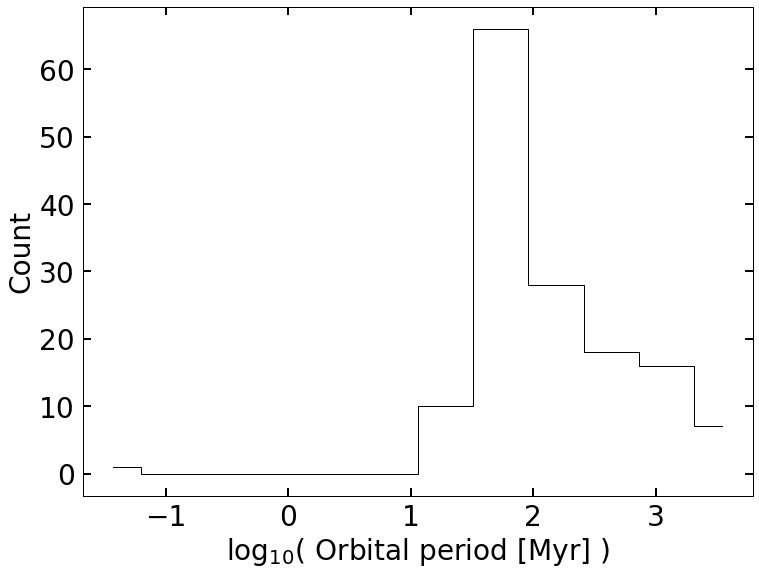

In [32]:
fig, ax = pyplot.subplots(figsize=(12, 9))

counts, edges = numpy.histogram(numpy.log10(MW_Tr_Myr), bins=12)
ax.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", c="k")

ax.set_xlabel("$\log_{10}$( Orbital period [Myr] )")
ax.set_ylabel("Count")

pyplot.show()

In [4]:
# print(shc.observations["Mass"])  # MSun
# print(shc.observations_ref["Mass"])  # MSun

# TODO: SupaHarrisClient --> how to filter specific parameters for a given reference?
# print(shc.observations["R_Sun"])  # kpc
# print(shc.observations_ref["R_Sun"])  # kpc

# Tidal radius according to eq. 8 of Webb et al. (2013), ApJ 764, 124
# print(shc.observations["sp_r_t"])  # arcmin
# bla = [print(rt) for (rt, distance_pc) in zip(shc.observations["sp_r_t"], shc.observations["R_Sun"])]

           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     NGC 104        6.02      -72.08    4.50      -17.21    5.24      -2.52     5.34      7.40      
SupaHarris NGC 104        6.02      -72.08    4.50      -18.00    5.25      -2.53     5.46      7.44      761000.00 92.56     
121.19525959367937 pc

Mass:    7.61e+05 solMass
r_t:     121.20 pc
t_cross: 22.80 Myr (at the tidal radius)


The orbital period is 133.59 Myr

10 disk crossings, at [0.         0.0313518  0.09620051 0.1815929  0.25073186 0.32952387
 0.40757334 0.47720733 0.5623522  0.62720092] Gyr

peaks:
 [ 380  762 1165 2201 2340 3038 3993 4939 5659 5784 6816 7243 7602]
properties:
 {}
time:
 [0.0313518  0.0628686  0.096118   0.1815929  0.19306106 0.25064935
 0.32944137 0.40749084 0.46689424 0.47720733 0.5623522  0.59758172
 0.62720092]
peak_widths [Myr]:
 [ 0.47965666 38.27484845  0.33961748  0.49073635 14.33722936  0.36735194
  0.50629048  0.

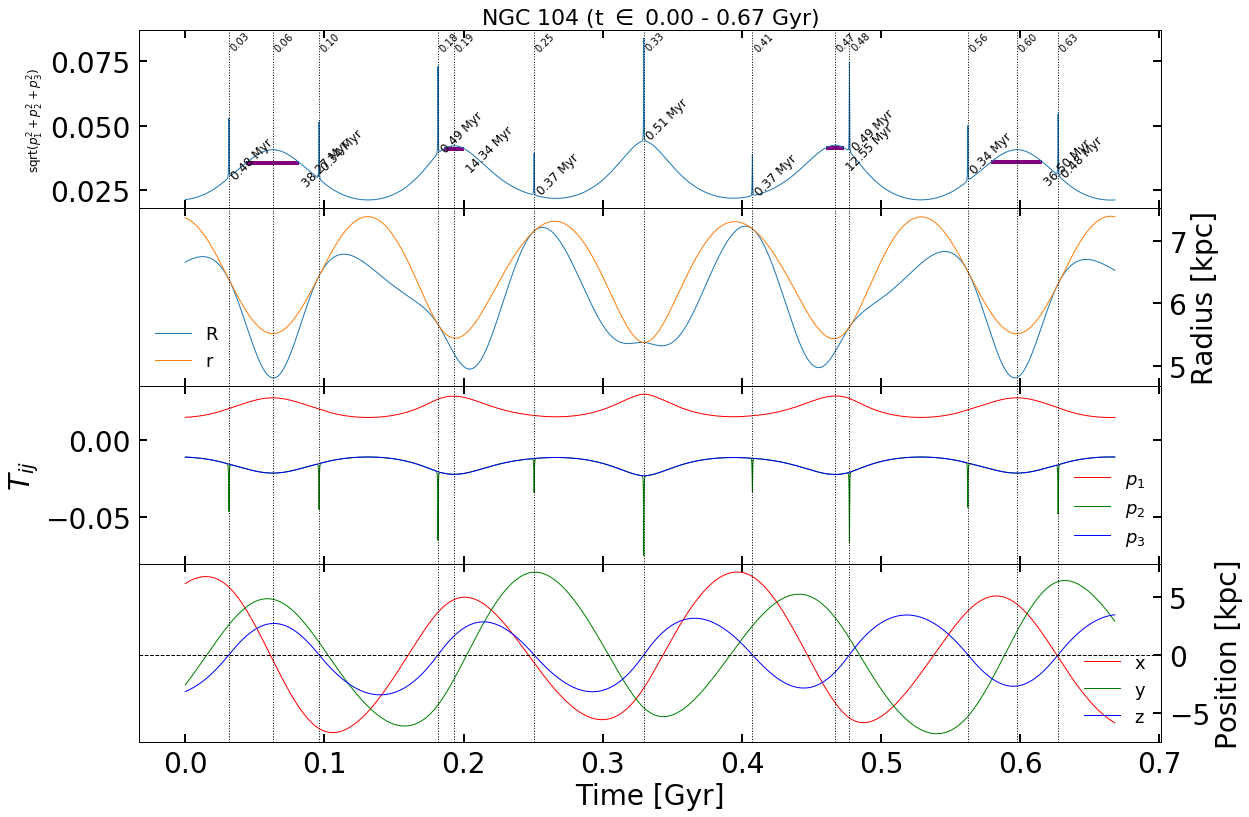

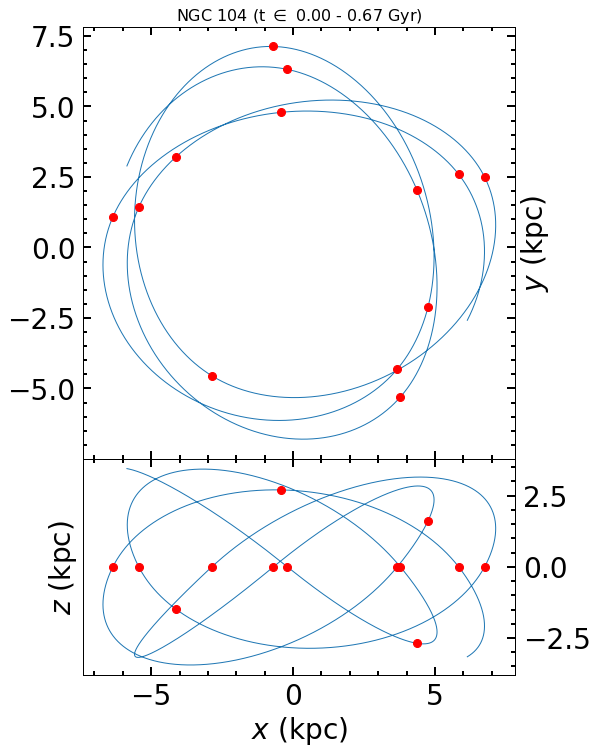

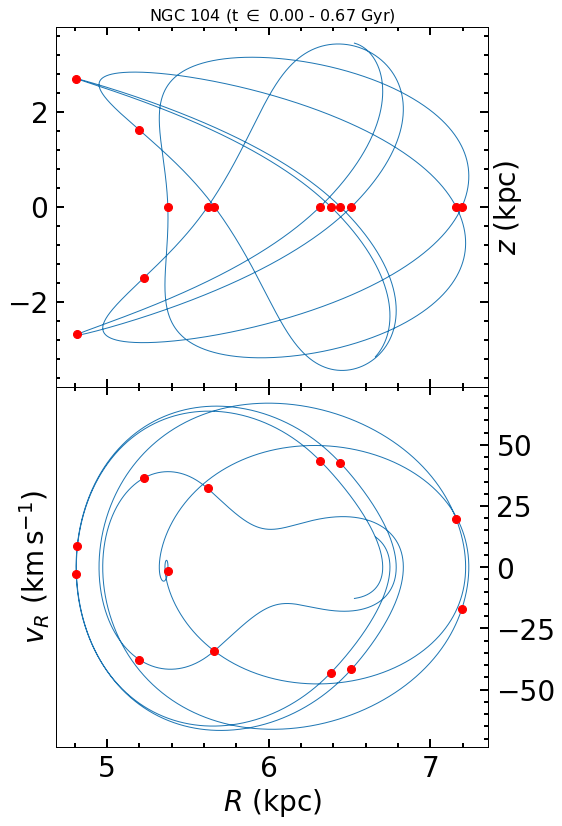

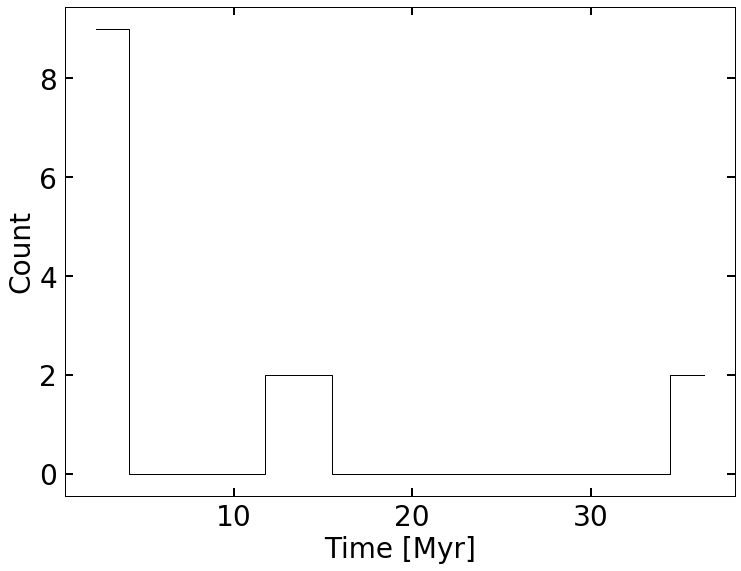

Orbit      NGC 104        6.02      -72.08    4.50      -18.00    5.25      -2.53     5.38      7.40      


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     NGC 288        13.19     -26.58    8.90      -44.83    4.27      -5.64     2.86      12.21     
SupaHarris NGC 288        13.19     -26.58    8.90      -45.40    4.22      -5.65     3.33      13.01     121000.00 33.94     
87.87635270541081 pc

Mass:    1.21e+05 solMass
r_t:     87.88 pc
t_cross: 35.31 Myr (at the tidal radius)


The orbital period is 168.67 Myr

8 disk crossings, at [0.         0.0613558  0.13260769 0.24719407 0.40219819 0.50240918
 0.58741144 0.74199888] Gyr

peaks:
 [ 588  683 1272 2337 2372 3861 3911 4822 5568 5638 7123 7145]
properties:
 {}
time:
 [0.06125163 0.07114772 0.13250352 0.24344397 0.2470899  0.40219819
 0.40740666 0.50230502 0.58001541 0.58730727 0.74199888 0.74429061]
peak_widths [Myr]:
 [20.1728213  11.378346

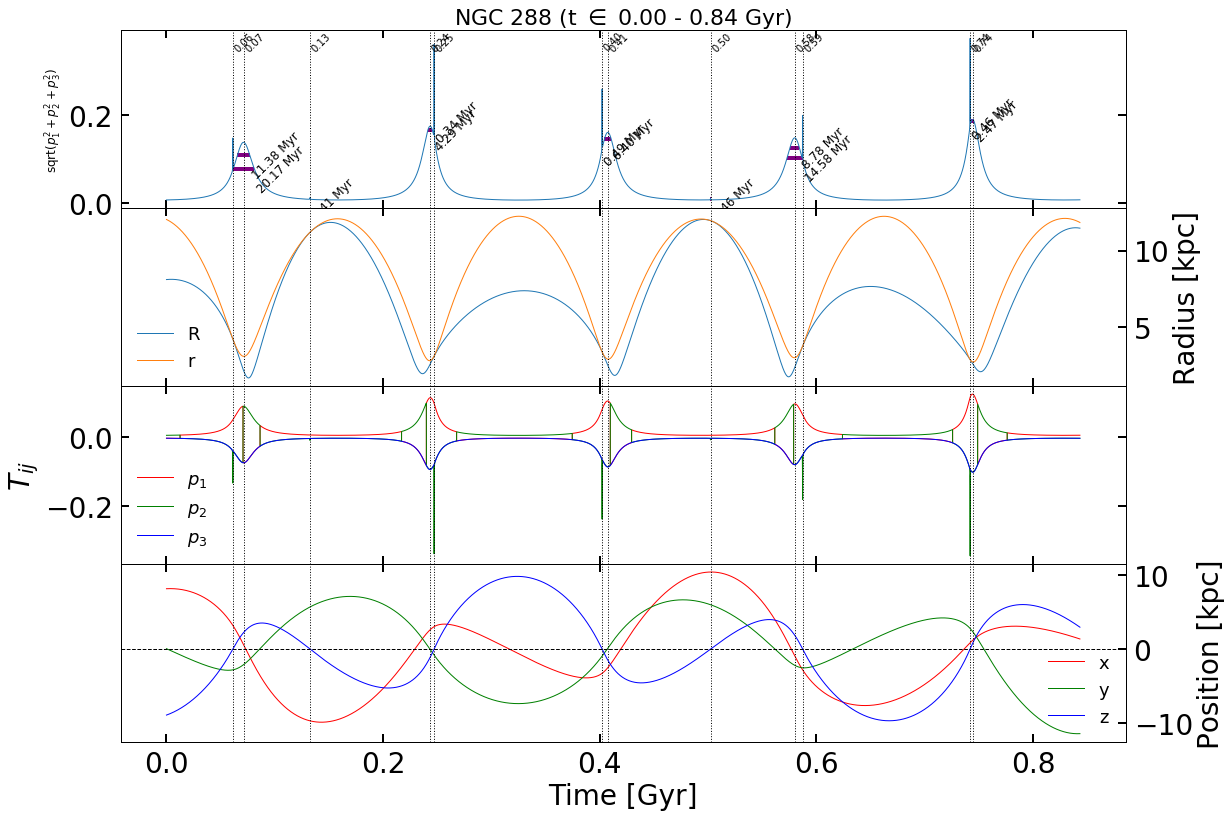

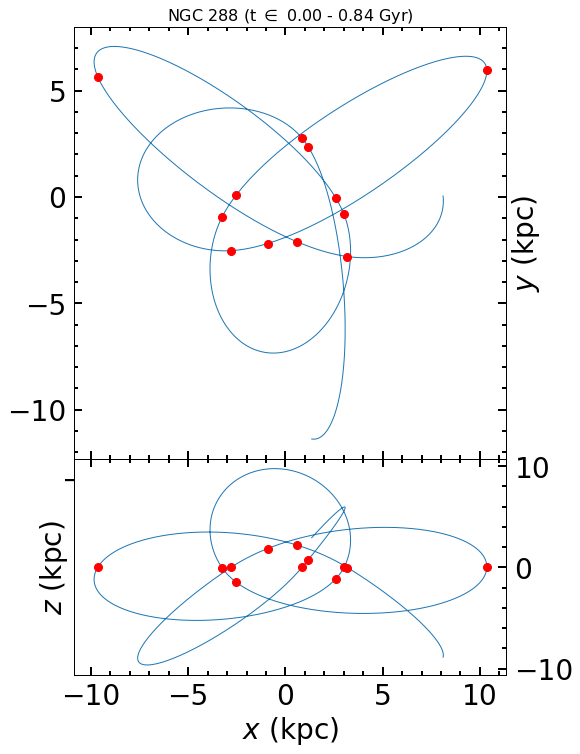

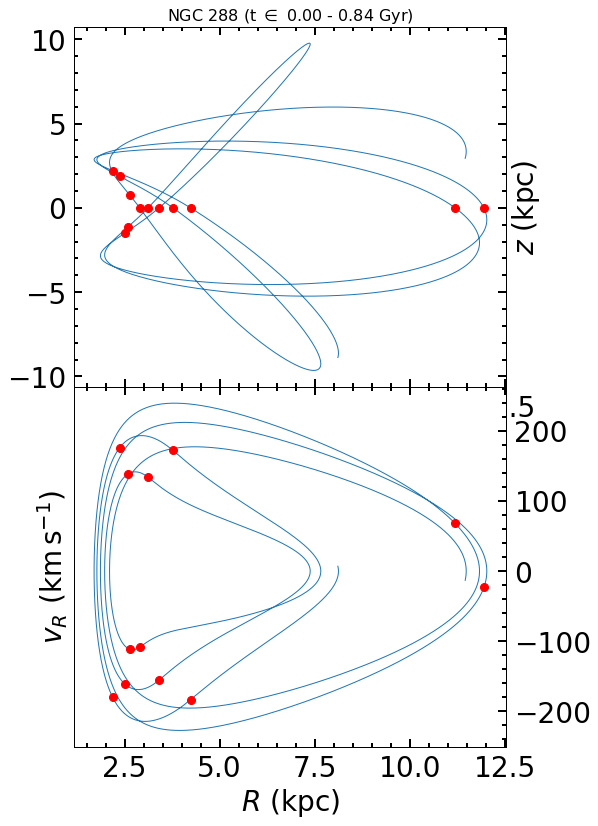

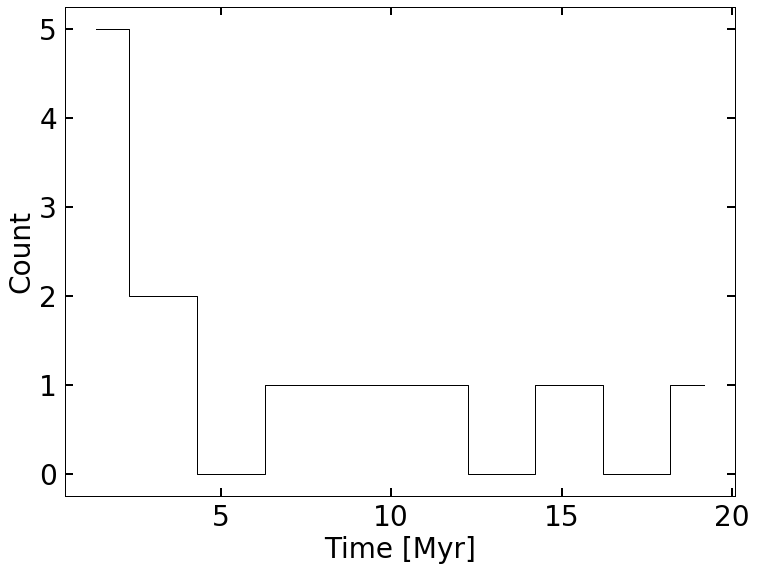

Orbit      NGC 288        13.19     -26.58    8.90      -45.40    4.22      -5.65     2.73      12.23     


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     NGC 362        15.81     -70.85    8.60      223.26    6.73      -2.54     0.43      12.84     
SupaHarris NGC 362        15.81     -70.85    8.60      223.50    6.71      -2.51     1.05      12.48     333000.00 41.38     
103.51886586695734 pc

Mass:    3.33e+05 solMass
r_t:     103.52 pc
t_cross: 27.21 Myr (at the tidal radius)


The orbital period is 166.31 Myr

8 disk crossings, at [0.         0.11205839 0.14369357 0.29129019 0.44751458 0.5439608
 0.61965927 0.7753701 ] Gyr

peaks:
 [1090 1246 1399 2835 4357 4382 5296 5997 6033 7548]
properties:
 {}
time:
 [0.11195568 0.12797869 0.14369357 0.29118747 0.44751458 0.45008237
 0.5439608  0.61596165 0.61965927 0.77526739]
peak_widths [Myr]:
 [ 0.26248859 11.35415803  0.26139833  0.17400923  0.2

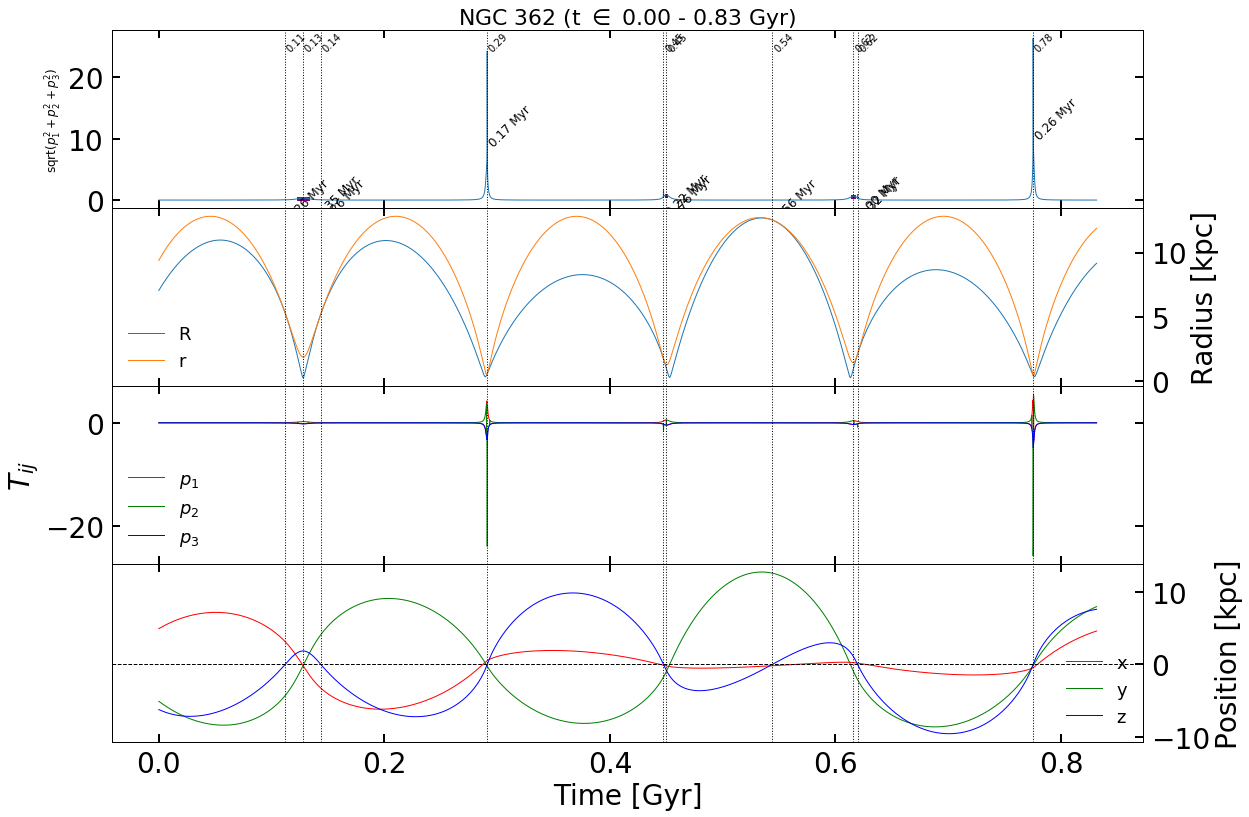

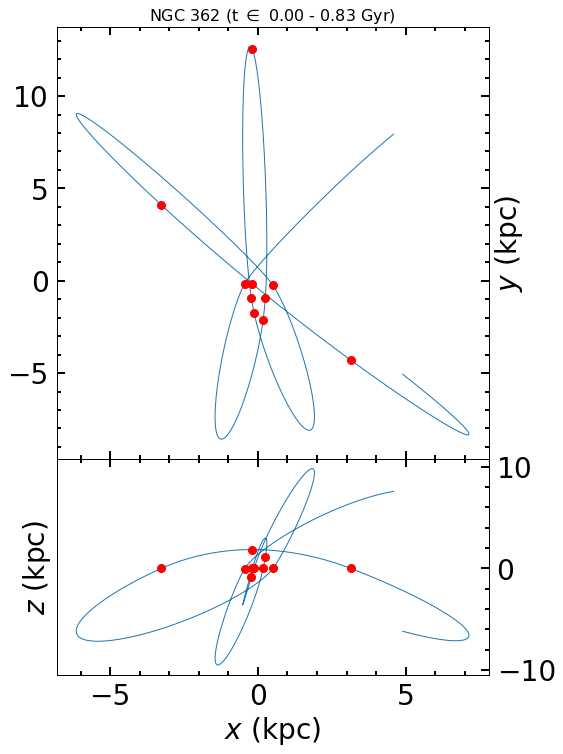

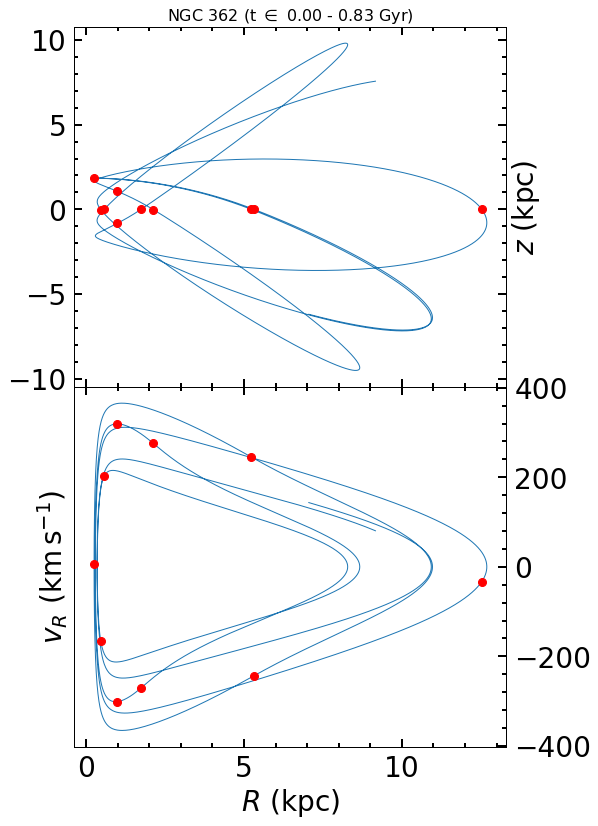

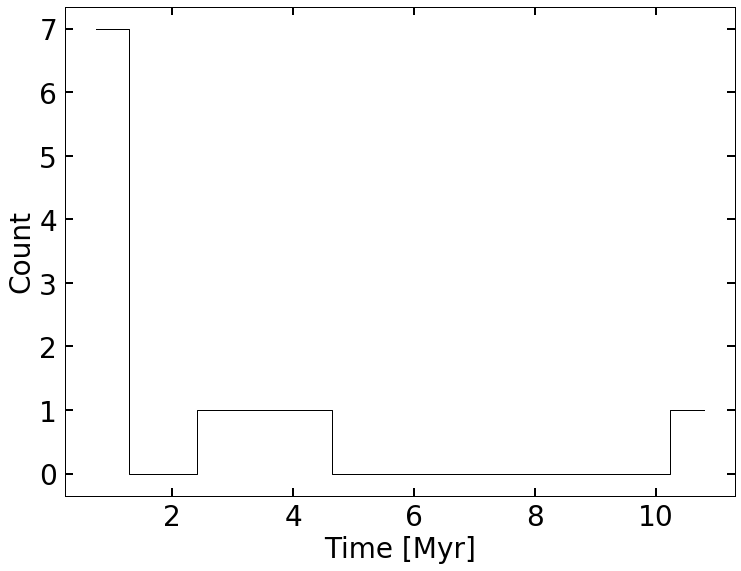

Orbit      NGC 362        15.81     -70.85    8.60      223.50    6.71      -2.51     0.43      12.82     


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     Whiting 1      30.74     -3.25     30.10     -130.41   -0.23     -1.78     20.70     73.28     
SupaHarris Whiting 1      30.74     -3.25     30.10     -130.60   -0.04     -1.78     17.64     53.27     1510.00   4.19      
36.67776357827474 pc

Mass:    1.51e+03 solMass
r_t:     36.68 pc
t_cross: 85.23 Myr (at the tidal radius)


The orbital period is 1038.16 Myr

8 disk crossings, at [0.         0.19106475 1.1386946  1.80806238 2.2908535  3.2333541
 4.025824   4.39961845] Gyr

peaks:
 [ 224  298 1776 1842 2820 3463 3573 5042 5081 6279 6702 6861]
properties:
 {}
time:
 [0.14361914 0.19106475 1.1386946  1.18101096 1.80806238 2.22032625
 2.2908535  3.23271295 3.25771807 4.025824   4.29703336 4.3989773 ]
peak_widths [Myr]:
 [110.96791146   0.5274

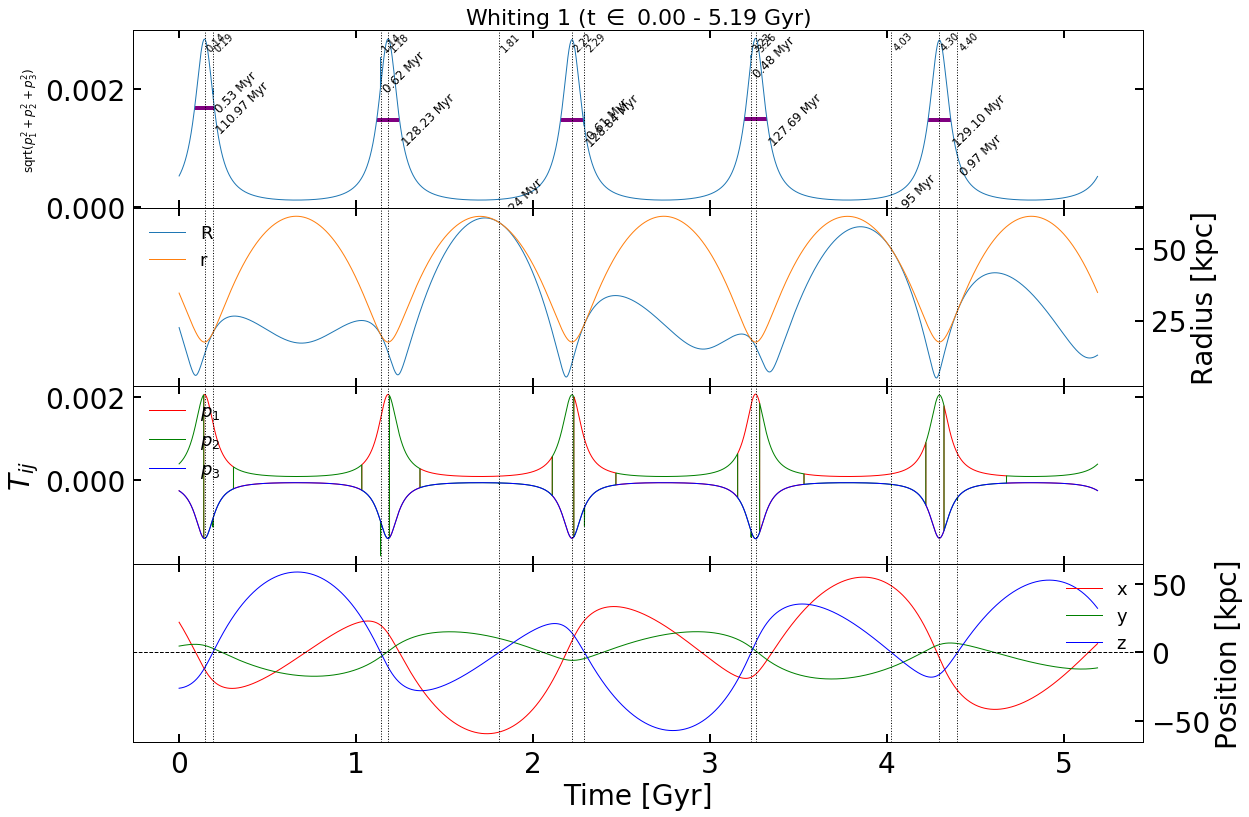

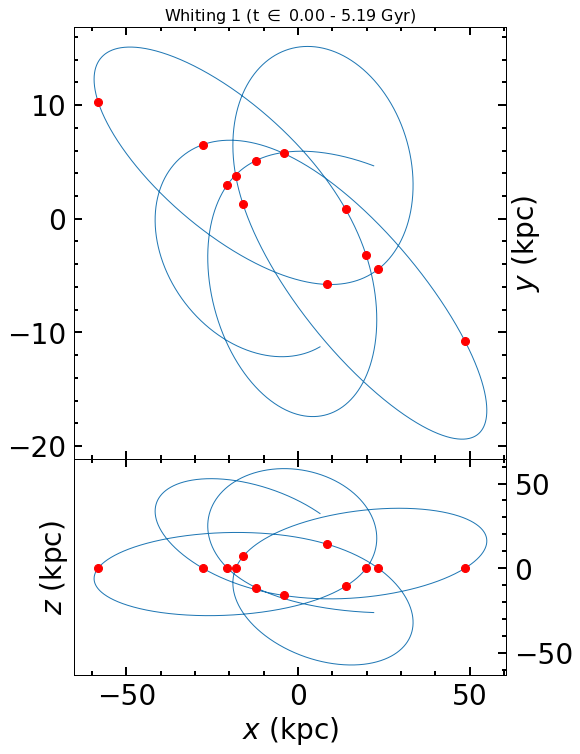

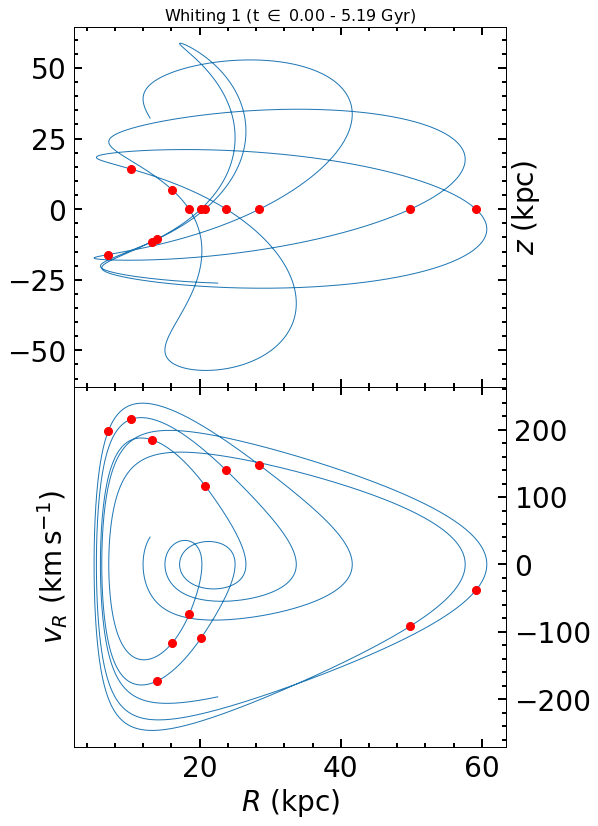

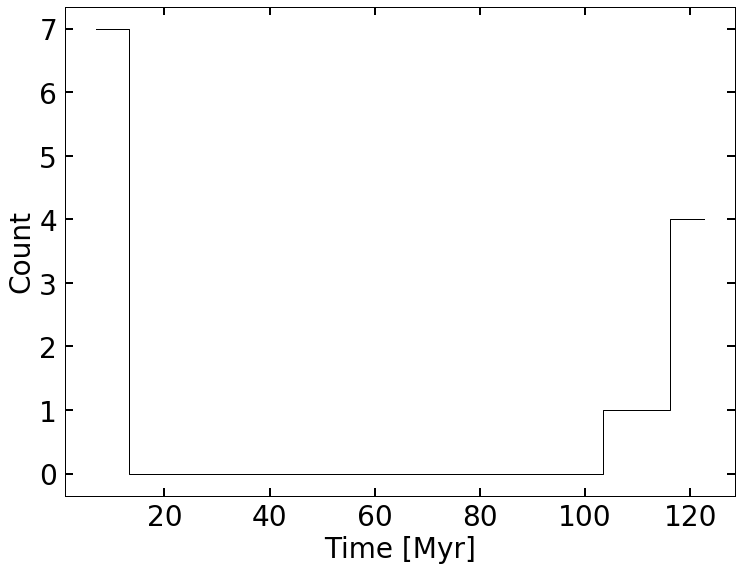

Orbit      Whiting 1      30.74     -3.25     30.10     -130.60   -0.04     -1.78     17.50     61.28     


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     NGC 1261       48.07     -55.22    16.30     71.36     1.63      -2.04     1.53      20.97     
SupaHarris NGC 1261       48.07     -55.22    16.30     68.20     1.61      -2.05     1.41      19.93     186000.00 27.10     
128.4848289218847 pc

Mass:    1.86e+05 solMass
r_t:     128.48 pc
t_cross: 50.35 Myr (at the tidal radius)


The orbital period is 276.94 Myr

8 disk crossings, at [0.         0.0773067  0.32633004 0.36857507 0.63145205 0.89535523
 0.94153401 1.18559741] Gyr

peaks:
 [ 452  456 1907 2079 2155 3691 5234 5300 5505 6924 6931]
properties:
 {}
time:
 [0.0773067  0.07799083 0.32615901 0.3555766  0.36857507 0.63128102
 0.8951842  0.90647234 0.94153401 1.18422915 1.18542638]
peak_widths [Myr]:
 [ 2.98772056  0.36640258  0.37273127 

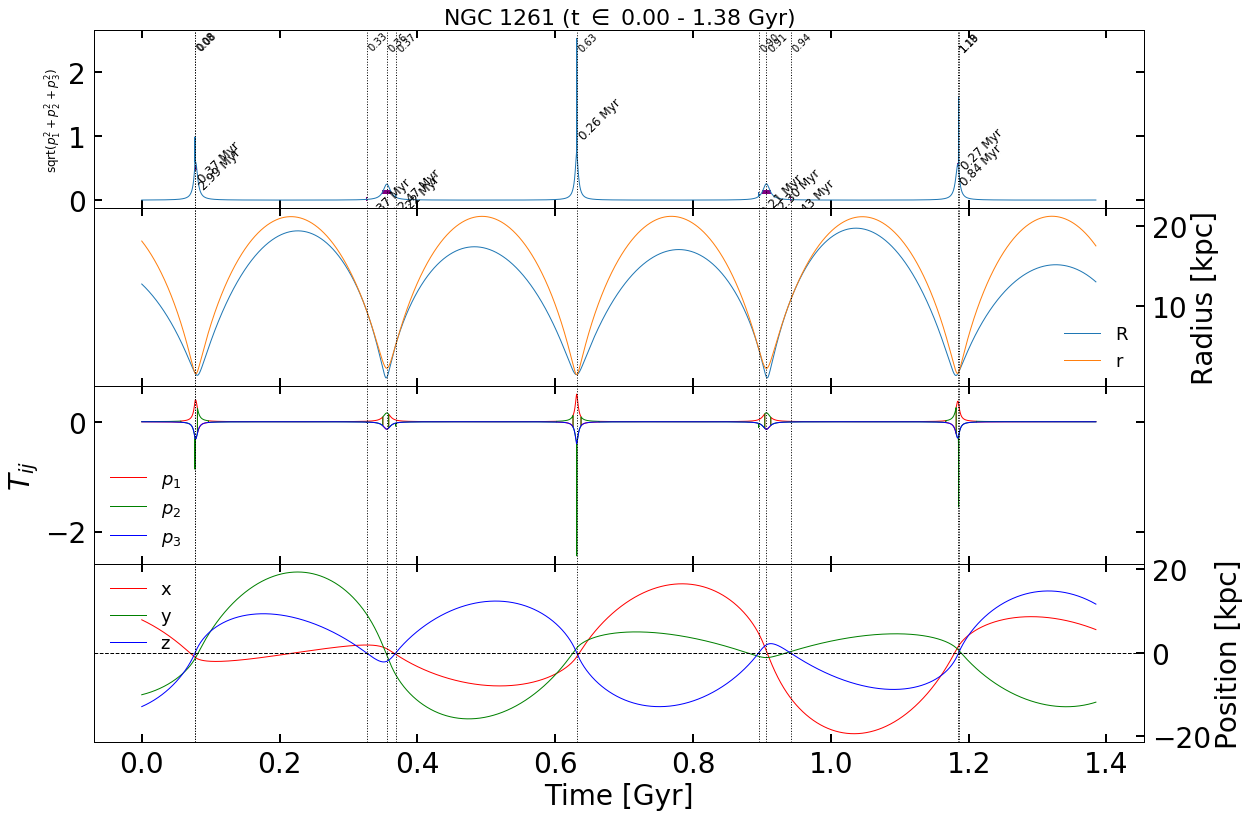

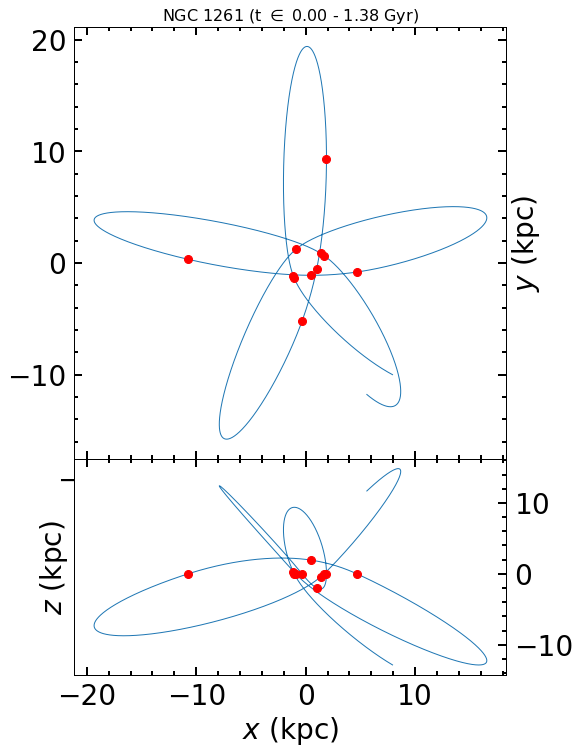

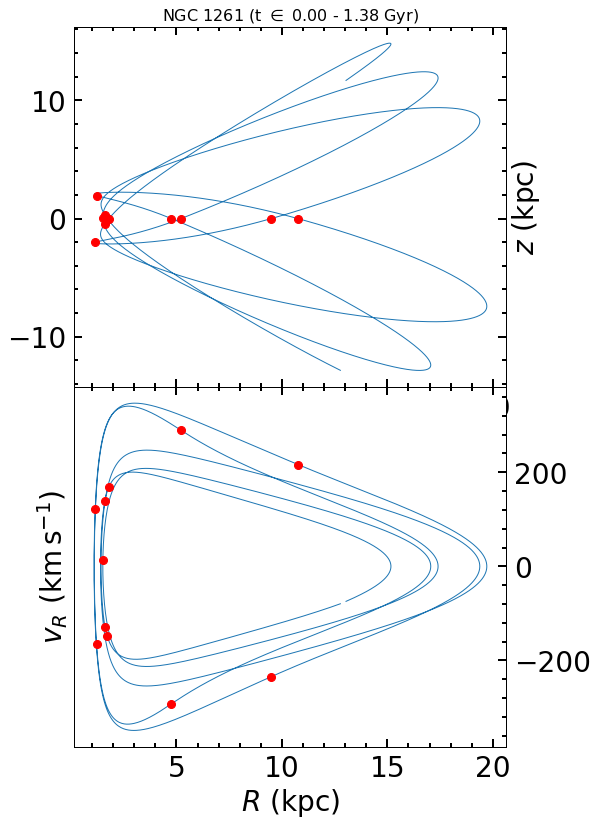

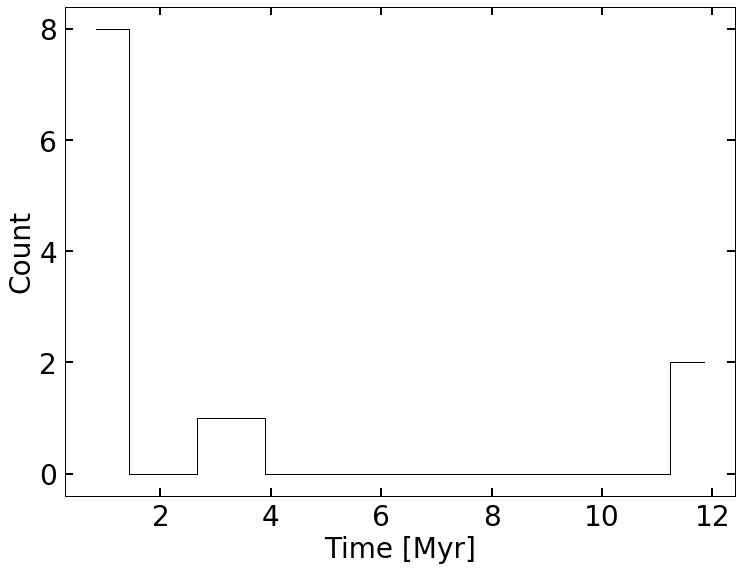

Orbit      NGC 1261       48.07     -55.22    16.30     68.20     1.61      -2.05     1.51      21.20     


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     Pal 1          53.33     79.58     11.10     -75.41    -0.17     0.07      15.11     18.70     
SupaHarris Pal 1          53.33     79.58     11.10     -82.80    -0.17     0.03      14.23     18.74     1790.00   8.03      
25.92354545454543 pc

Mass:    1.79e+03 solMass
r_t:     25.92 pc
t_cross: 46.51 Myr (at the tidal radius)


The orbital period is 379.97 Myr

10 disk crossings, at [0.         0.08166272 0.29520603 0.53198098 0.7321485  0.97244339
 1.17941614 1.40539659 1.63231569 1.83834979] Gyr

peaks:
 [ 347 1126 1258 2267 2743 3120 4144 4359 5026 5988 6956 7605 7834]
properties:
 {}
time:
 [0.08142805 0.26423052 0.29520603 0.53198098 0.64368056 0.7321485
 0.97244339 1.02289593 1.17941614 1.40516193 1.63231569 1.78461197
 1.83834979]
pea

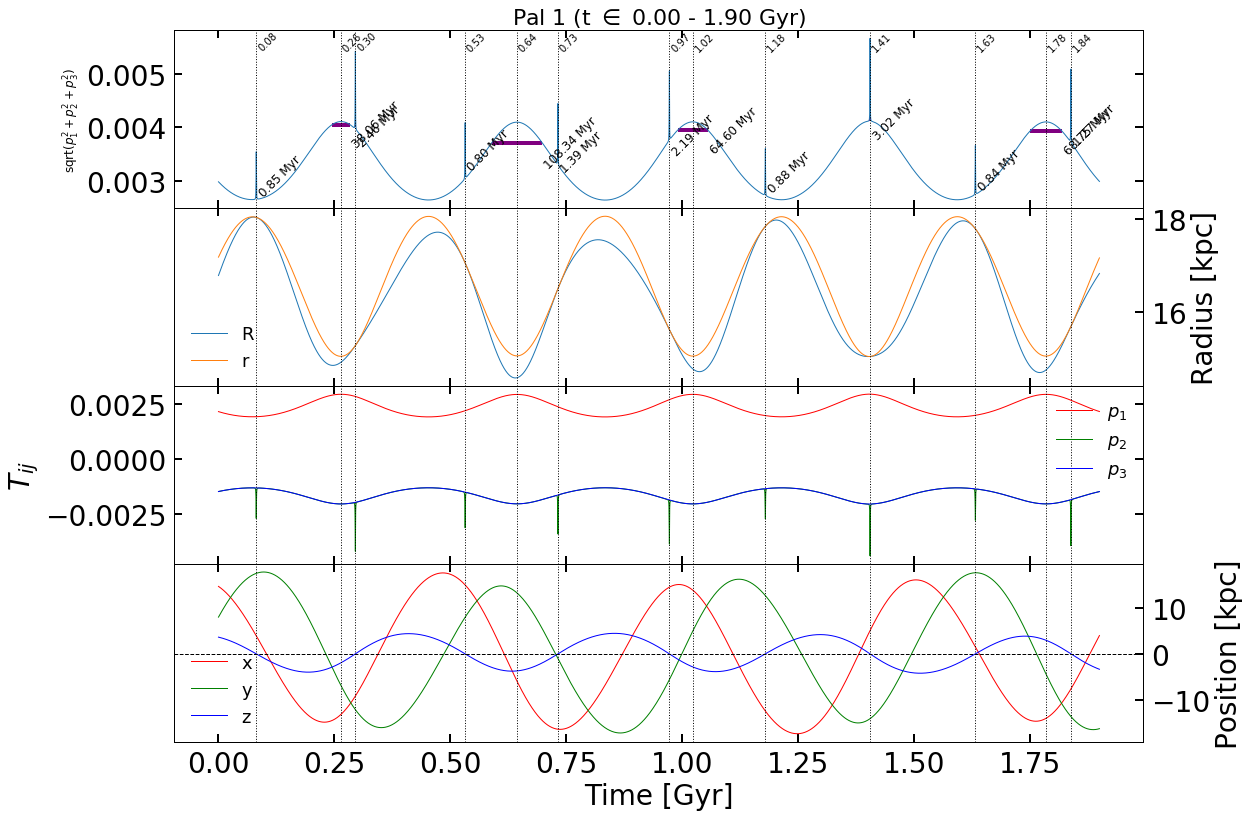

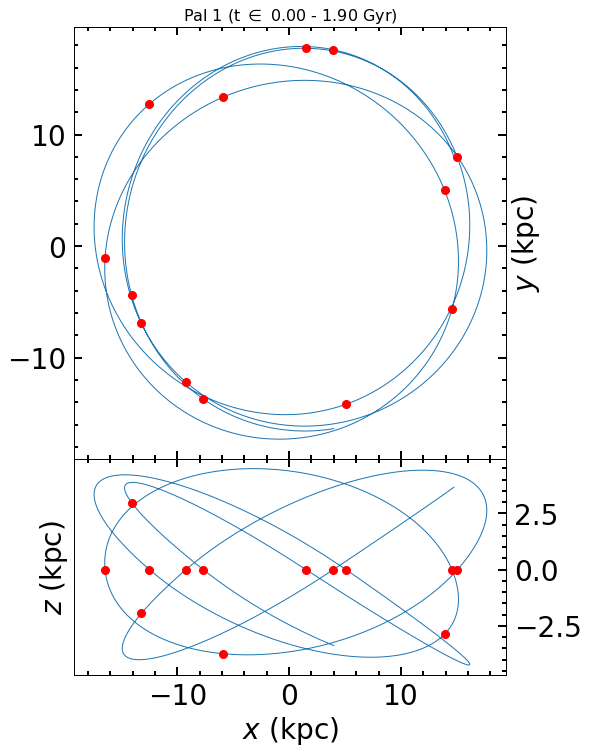

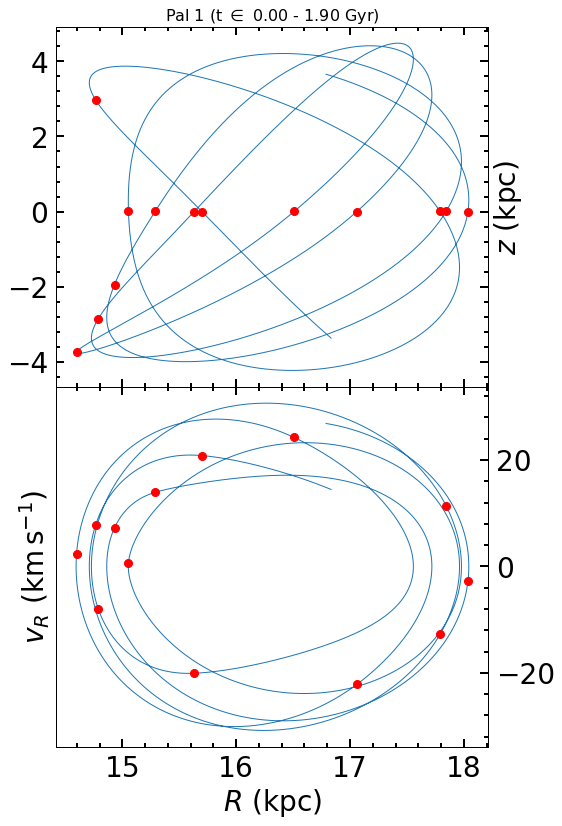

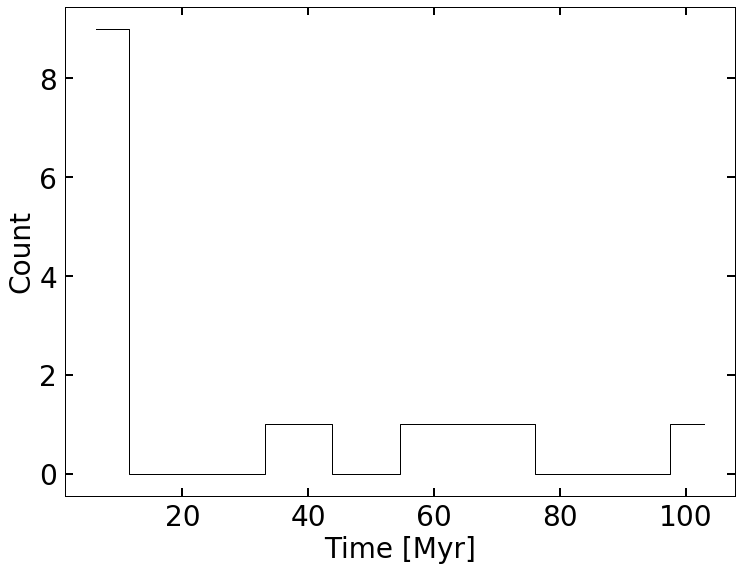

Orbit      Pal 1          53.33     79.58     11.10     -82.80    -0.17     0.03      15.05     18.06     


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     AM 1           58.76     -49.62    123.30    118.00    0.36      -0.42     113.13    189.55    
SupaHarris AM 1           58.76     -49.62    123.30    116.00    0.02      -0.25     98.84     308.34    31700.00  8.67      
310.9499999999997 pc

Mass:    3.17e+04 solMass
r_t:     310.95 pc
t_cross: 459.17 Myr (at the tidal radius)


The orbital period is 4859.42 Myr

8 disk crossings, at [ 1.3385002   5.07189538  7.59283746 10.62697132 14.21931379 16.39812801
 19.97846599 23.03960995] Gyr

peaks:
 [ 238 1690 1857 2529 3477 5096 6656 6715 7677]
properties:
 {}
time:
 [ 0.71426692  5.07189538  5.57308267  7.58983634 10.43489954 15.29371529
 19.97546487 20.15253104 23.03960995]
peak_widths [Myr]:
 [ 847.78899299    2.92356666 1340.08141407    2.97

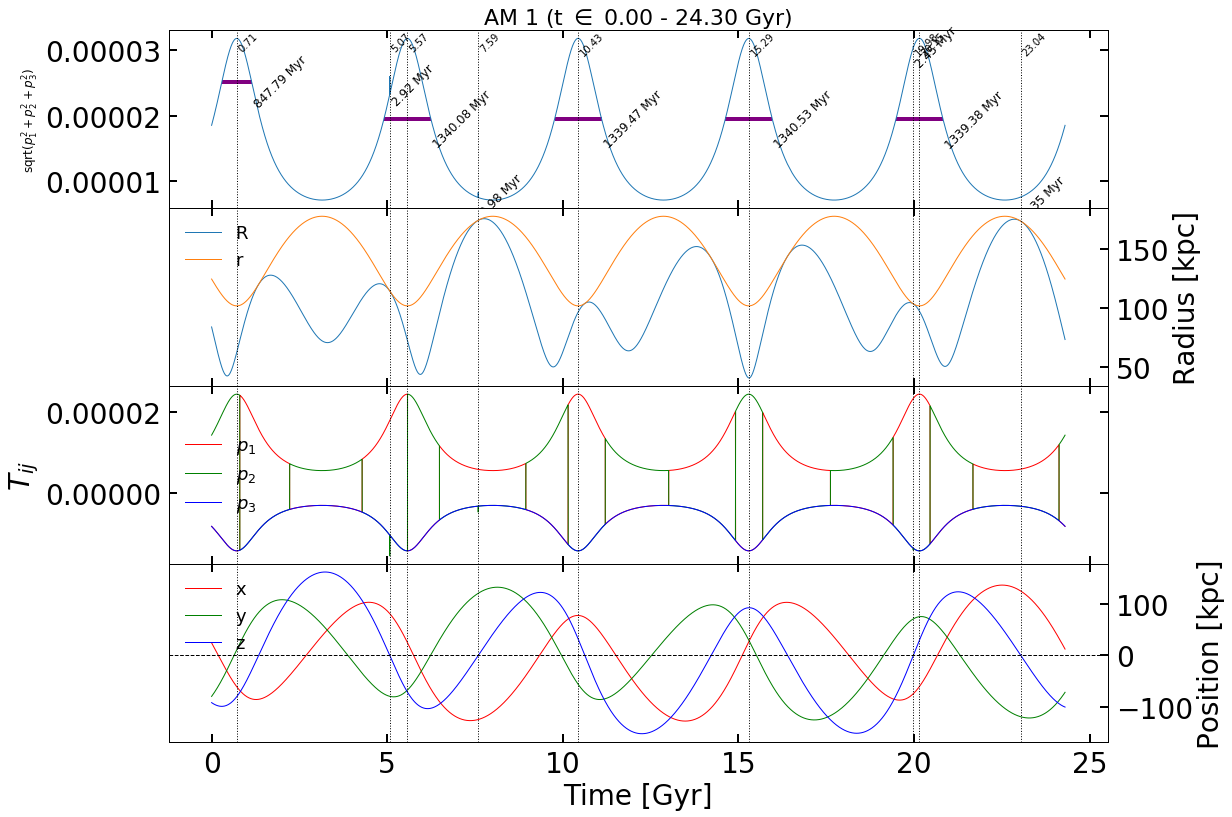

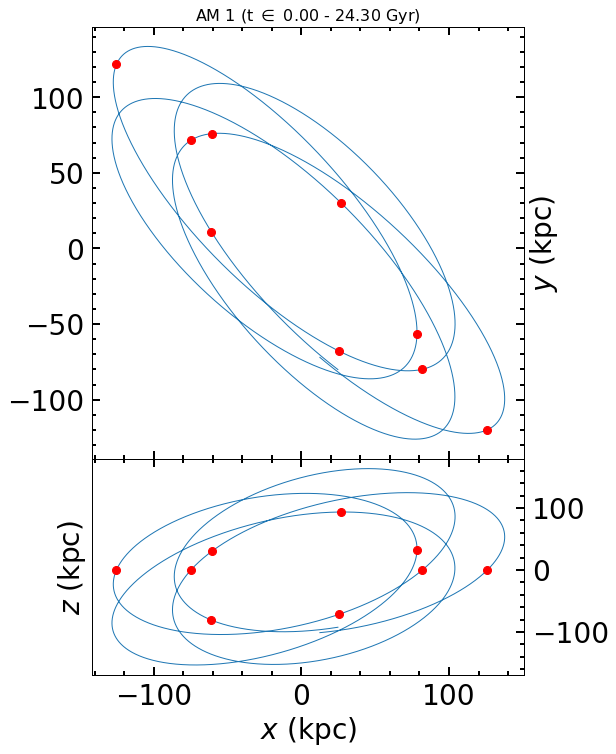

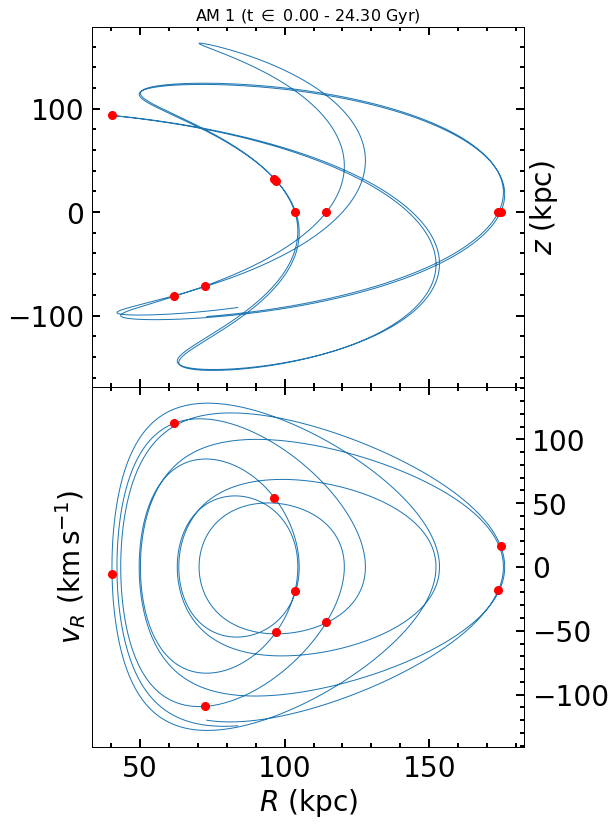

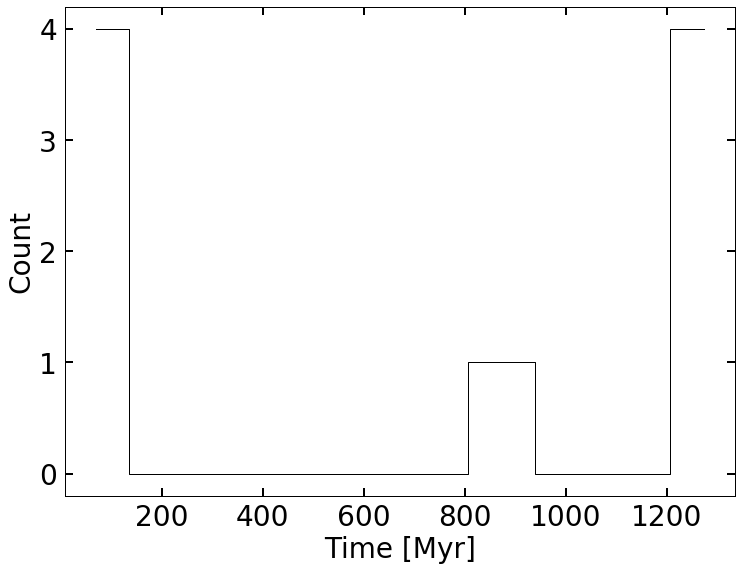

Orbit      AM 1           58.76     -49.62    123.30    116.00    0.02      -0.25     101.76    178.14    


           name           RA        Dec       R_Sun     v_r       pmRA      pmDec     R_peri    R_apo     Mass      sp_r_t    
SIMBAD     Eridanus       66.19     -21.19    90.10     -23.79    0.49      -0.40     19.88     164.97    
SupaHarris Eridanus       66.19     -21.19    90.10     -23.60    0.40      -0.12     33.56     134.93    11100.00  5.28      
138.50999999999988 pc

Mass:    1.11e+04 solMass
r_t:     138.51 pc
t_cross: 230.69 Myr (at the tidal radius)


The orbital period is 3297.17 Myr

8 disk crossings, at [ 0.35227959  1.93448332  3.82620438  6.94988588  8.58503336 10.42177437
 13.54749216 15.2355834 ] Gyr


In [ ]:
ts = numpy.linspace(0.0, 1, 8096+1) * u.Gyr
to_Gyr = bovy_conversion.time_in_Gyr(220.0, 8.0)

gc_data = []
required_parameters = ["RA", "Dec", "R_Sun", "v_r", "pmRA", "pmDec", "R_peri", "R_apo", "Mass", "sp_r_t"]
for i, gc_name in enumerate(shc.observations["name"]): 
    # if i > 0: break
    print("           {:<15s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}".format(
        *["name"]+required_parameters)
    )
    try:
        with warnings.catch_warnings(record=True) as w:
            o = Orbit.from_name(gc_name)
            o.integrate(ts, MWPotential2014)
    except ValueError as e:
        print("SIMBAD     {:<15s} died with error".format(gc_name))
    else:
        print("SIMBAD     {:<15s}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
            o.name, o.ra(), o.dec(), o.dist(), o.vlos(), o.pmra(), o.pmdec(), o.rperi(), o.rap()
        ))

    for required_parameter in required_parameters:
        if (shc.observations[required_parameter][i] == "" 
                or shc.observations[required_parameter][i] == "None"):
            print("SupaHarris {:<15s} cannot provide parameter {}".format(gc_name, required_parameter))
            break
    else:  # no break means we have all required data
        gc_data.append([
            gc_name, float(shc.observations["RA"][i]), 
            float(shc.observations["Dec"][i]),
            float(shc.observations["R_Sun"][i]),
            float(shc.observations["v_r"][i]),
            float(shc.observations["pmRA"][i]), 
            float(shc.observations["pmDec"][i]),
            float(shc.observations["R_peri"][i]),
            float(shc.observations["R_apo"][i]),
            float(shc.observations["Mass"][i]) if shc.observations["Mass"][i] else "",
            float(shc.observations["sp_r_t"][i]) if shc.observations["sp_r_t"][i] else "",
        ])
        print("SupaHarris {:<15s}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
            *gc_data[-1]
        ))  
        
        distance_kpc = shc.observations["R_Sun"][i]
        mass = gc_data[-1][9] * u.Msun
        r_t = (arcmin2parsec(gc_data[-1][10], distance_kpc) * u.parsec).to(u.parsec)
        print(r_t)
        t_cross = numpy.sqrt(r_t**3 / const.G / mass).to(u.Myr)
        print("\nMass:    {:.2e}\nr_t:     {:.2f}\nt_cross: {:.2f} (at the tidal radius)\n".format(mass, r_t, t_cross))
            
        o = Orbit([
            gc_data[-1][1]*u.deg, gc_data[-1][2]*u.deg, gc_data[-1][3]*u.kpc,  # RA (deg), DEC (deg), d (kpc)
            gc_data[-1][5]*u.mas/u.year, gc_data[-1][6]*u.mas/u.year,  # mu_ra (mas/yr), mu_dec (mas/yr)
            gc_data[-1][4]*u.km/u.s],  # radial velocity (km/s)
            radec=True, uvw=False, lb=False  # explicit tell Orbit init which input method we use
        )
        period = o.Tr(pot=MWPotential2014)  # Gyr
        print("\nThe orbital period is {:.2f} Myr".format(1000*period))
        o.name = gc_name
        ts = numpy.linspace(0.0, 5*period, 8096+1) * u.Gyr
        o.integrate(ts, MWPotential2014)
        zsign = np.sign(o.z(o.t))
        signchange = ((np.roll(zsign, 1) - zsign) != 0).astype(int)
        disk_crossing, = numpy.where(signchange == 1)
        print("\n{} disk crossings, at {} Gyr".format(
            len(disk_crossing), o.time()[disk_crossing])
        )
        
        # Plot temporal evolution of ttensor w/ R(t), x(t)/y(t)/z(t) and find peaks
        fig, peaks, results_half = plot_ttensor(o)
        pyplot.savefig("../out/{0}_ttensor_{1:.2f}Gyr.png".format(o.name, o.time()[-1]), bbox_inches="tight")
        pyplot.show()

        fig = plot_orbit_xyz(o, o.t[peaks])
        pyplot.savefig("../out/{0}_xyz_{1:.2f}Gyr.png".format(o.name, o.time()[-1]), bbox_inches="tight")
        pyplot.show()
        fig = plot_orbit_Rz(o, o.t[peaks])
        pyplot.savefig("../out/{0}_Rz_{1:.2f}Gyr.png".format(o.name, o.time()[-1]), bbox_inches="tight")
        pyplot.show()

        # What does the potential look like at these locations?
        # plot_potential(o, o.time()[peaks])

        # Histogram of the shock duration
        time_range = o.time()[-1] - o.time()[0]
        bin_to_Gyr = time_range / len(o.time())
        Gyr_to_Myr = 1000.

        fig, ax = pyplot.subplots()
        counts, edges = numpy.histogram(results_half[0]*bin_to_Gyr*Gyr_to_Myr)
        ax.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", c="k")
        ax.set_xlabel("Time [Myr]")
        ax.set_ylabel("Count")
        pyplot.savefig("../out/{0}_tshock_{1:.2f}Gyr.png".format(o.name, o.time()[-1]), bbox_inches="tight")
        pyplot.show()


        print("Orbit      {:<15s}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
            o.name, o.ra(), o.dec(), o.dist(), o.vlos(), o.pmra(), o.pmdec(), o.rperi(), o.rap()
        ))

    print("\n")

$$t_{\rm cross} = \frac{R}{v} = \sqrt{ \frac{R^3}{GM} } = \frac{1}{ \sqrt{G \rho} } $$

## Integrate and plot our selected GCs 

In [ ]:
for gc, gc_name in zip(GC_DATA, CLUSTERS):
    o = Orbit([
        gc[1]*u.deg, gc[2]*u.deg, gc[3]*u.kpc,  # RA (deg), DEC (deg), d (kpc)
        gc[5]*u.mas/u.year, gc[6]*u.mas/u.year,  # mu_ra (mas/yr), mu_dec (mas/yr)
        gc[4]*u.km/u.s],  # radial velocity (km/s)
        radec=True, uvw=False, lb=False  # explicit tell Orbit init which input method we use
    )
    o.name = gc_name
    print("Orbit: {0}".format(o.name))


    pyplot.show()

In [51]:
print(o.time()[-1])
print(o.t[-1])
print(o.t[-1]*bovy_conversion.time_in_Gyr(220.0, 8.0))

1.0
28.12458453897696
1.0


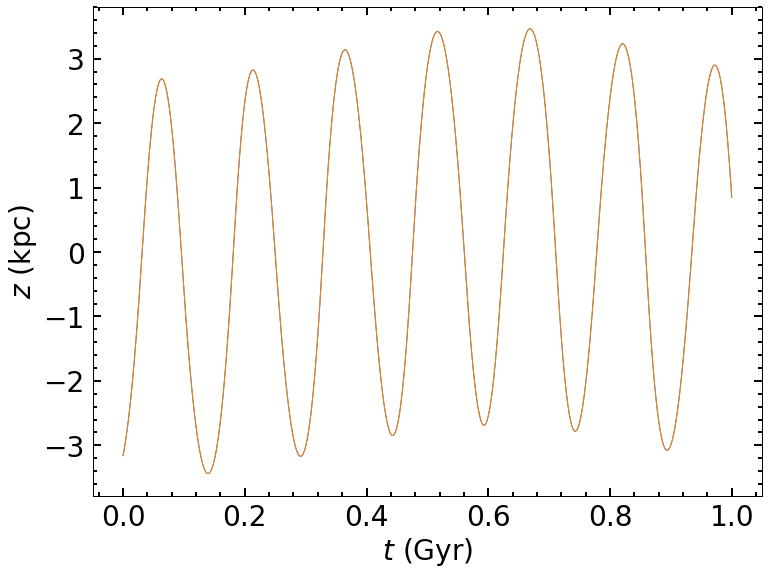

In [53]:
ts = numpy.linspace(0.0, 1, 8096+1)
ts_Gyr = bovy_conversion.time_in_Gyr(220.0, 8.0)*ts
o = Orbit.from_name("NGC 104")
o.integrate(ts*u.Gyr, MWPotential2014)
fig, ax = pyplot.subplots()
ax.plot(o.time(), o.z(o.t))  # <--- o.time() [Gyr]; o.t [internal]
o.plot(d1="t", d2="z", gcf=True)
pyplot.show()

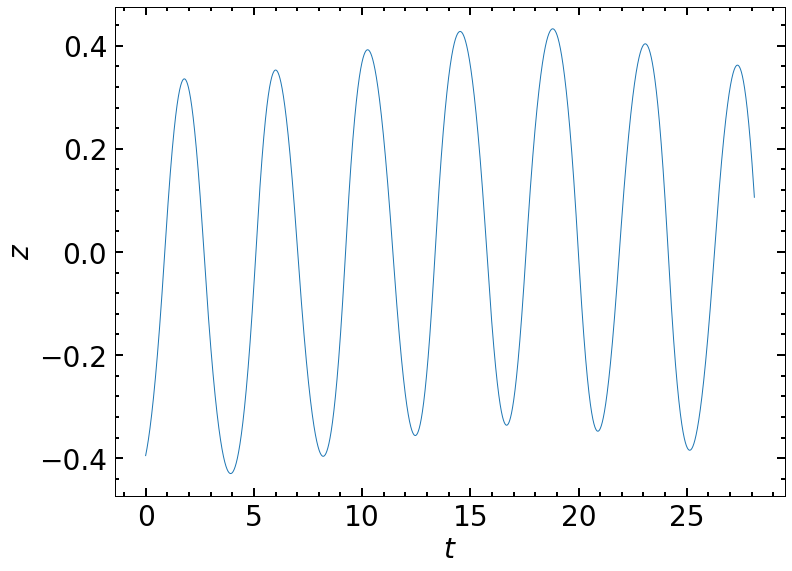

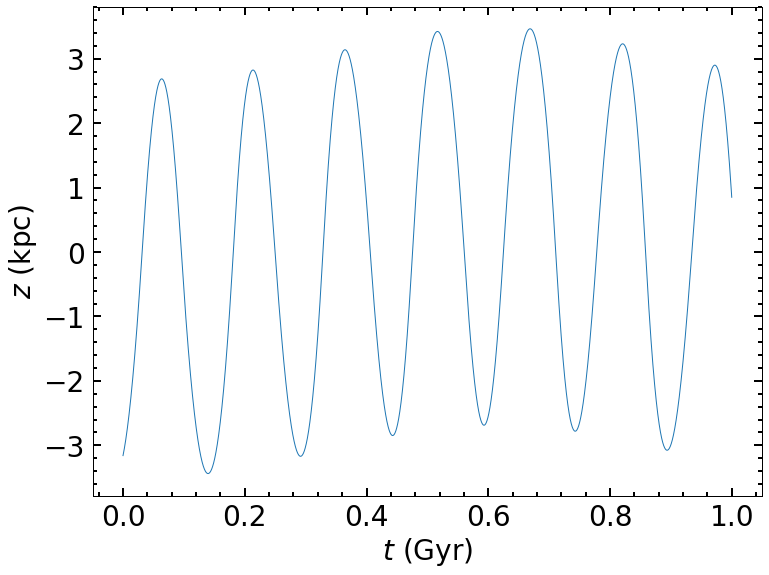

In [46]:
o.plot(d1="t", d2="z", use_physical=False)
o.plot(d1="t", d2="z", use_physical=True)

In [47]:
o.plot?

In [ ]:
try:
    numpy.testing.assert_array_equal(ts, o.t)
except AssertionError as e:
    print("ts is not equal to o.t")
    print(e)
else:
    print("ts is equal to o.t")
    
try:
    numpy.testing.assert_array_equal(ts, o.time())
except AssertionError as e:
    print("ts is not equal to o.time()")
    print(e)
else:
    print("ts is equal to o.time()")

try:
    numpy.testing.assert_array_equal(ts_Gyr, o.t)
except AssertionError as e:
    print("ts_Gyr is not equal to o.t")
    print(e)
else:
    print("ts_Gyr is equal to o.t")

try:
    numpy.testing.assert_array_equal(ts_Gyr, o.time())
except AssertionError as e:
    print("ts_Gyr is not equal to o.time()")
    print(e)
else:
    print("ts_Gyr is equal to o.time()")